In [1]:
import os
import yaml
import numpy as np
import matplotlib.pyplot as plt
import glob
import monai
from PIL import Image
import torch
from monai.networks.nets import SwinUNETR
from monai.transforms import Transform
from monai.transforms import Compose, Flipd, Rotate90d, RandFlipd, RandRotate90d, RandSpatialCropd
import warnings
warnings.filterwarnings("ignore")
from monai.data import CacheDataset, DataLoader
import torch.nn.functional as F 
import zipfile
from tqdm import tqdm
import wandb
from datetime import datetime
### our modules
from dataset import *
from training import *
from testing import *
from preprocessing import *
from models import *
from regularization import *

# Install additional packages 
#!pip install scikit-image
#!pip install wandb
#!pip install monai==1.2.0        
#!pip install imagecodecs
#!pip install opencv-python
#!pip install einops
#!pip install pyyaml

/home/jovyan/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "
2025-04-04 12:17:11.890427: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-04 12:17:11.907863: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743761831.924934   98759 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory 

In [2]:
# Load config
with open("configs.yaml", "r") as f:
    config = yaml.safe_load(f)
    
dataset = config["dataset_paths"][config["dataset_index"]]
if not os.path.exists(dataset):
    print("Please update your data path to an existing folder.")
elif not set(["training", "test"]).issubset(set(os.listdir(dataset))):
    print("Please update your data path to the correct folder (should contain train and test folders).")
else:
    print(f"Congrats! You selected the correct folder : {dataset}")

Congrats! You selected the correct folder : ../datasets/DRIVE_dataset/datasets/


In [3]:
## configs

# Device
##device = torch.device("cuda" if torch.cuda.is_available() else "cpu") if config["device"] == "auto" else torch.device(config["device"])
device = torch.device("cuda:3" if torch.cuda.is_available() else "cpu")

# Loss function
##loss_fn = DiceLoss(sigmoid=True, batch=True) if config["loss"] == "DiceLoss" else None  # Extend as needed

batch_size = config["batch_size"]
num_workers = config["num_workers"]
n_epochs = config["n_epochs"]
ensemble_models = config["ensemble_models"]
save_path = config["save_path"]
split_ratio = config["split_ratio"]

## Dataset with Monai

In [4]:
def build_dict_vessels(data_path, mode='training'):
    """
    This function returns a list of dictionaries, each dictionary containing the keys 'img' and 'mask' 
    that returns the path to the corresponding image.
    
    Args:
        data_path (str): path to the root folder of the data set.
        mode (str): subset used. Must correspond to 'train' or 'test'.
        
    Returns:
        (List[Dict[str, str]]) list of the dictionaries containing the paths of images and masks.
    """
    # test if mode is correct
    if mode not in ["training", "test"]:
        raise ValueError(f"Please choose a mode in ['train', 'test']. Current mode is {mode}.")
    
    # define empty dictionary
    dicts = []
    # list all files in directory, including the path
    paths_retina = glob.glob(os.path.join(data_path, mode, 'images', '*.tif'))
    #print(paths_retina)
        
    for retina_path in paths_retina:
        image_index = os.path.basename(retina_path).split('_')[0]
        mask_path = os.path.join(data_path, mode, '1st_manual', f'{image_index}_manual1.gif')
        #padding_mask_path = os.path.join(data_path, mode, 'mask', f'{image_index}_mask.gif')
        padding_mask_path = os.path.join(data_path, mode, 'mask', f'{image_index}_{mode}_mask.gif')

        #print(padding_mask_path)

        entry = {'img': retina_path}

        # Add segmentation mask if it exists
        if os.path.exists(mask_path):
            #print("mask exist")
            entry['mask'] = mask_path

        # Add valid region mask (padding mask) if it exists
        if os.path.exists(padding_mask_path):
            #print("padding_mask exist")

            entry['valid_mask'] = padding_mask_path

        dicts.append(entry)

    return dicts

class LoadVesselData(Transform):
    """
    This custom Monai transform loads and processes data from the rib segmentation dataset.
    It handles RGB image loading, resizing, normalization, and binary mask conversion.
    """
    def __init__(self, keys=None):
        super().__init__()
        self.keys = keys

    def __call__(self, sample):
        try:
            # Load and process the image
            image = Image.open(sample['img']).convert('L')
            image = image.resize((512, 512), resample=Image.Resampling.NEAREST)
            image = np.array(image, dtype=np.float32) / 255.0
            image = torch.from_numpy(image).unsqueeze(0)  # [1, H, W]

            # Initialize output dictionary
            output = {
                'img': image,
                'img_meta_dict': {'affine': np.eye(2)}
            }

            # Load segmentation mask if it exists
            if 'mask' in sample and os.path.exists(sample['mask']):
                mask = Image.open(sample['mask']).convert('L')
                mask = mask.resize((512, 512), resample=Image.Resampling.NEAREST)
                mask = np.array(mask, dtype=np.uint8)
                mask = np.where(mask == 255, 1, 0)
                mask = torch.from_numpy(mask).unsqueeze(0).float()
                output['mask'] = mask
                output['mask_meta_dict'] = {'affine': np.eye(2)}

            # Load valid (padding) mask if it exists
            if 'valid_mask' in sample and os.path.exists(sample['valid_mask']):
                valid_mask = Image.open(sample['valid_mask']).convert('L')
                valid_mask = valid_mask.resize((512, 512), resample=Image.Resampling.NEAREST)
                valid_mask = np.array(valid_mask, dtype=np.uint8)
                valid_mask = np.where(valid_mask == 255, 1, 0)
                valid_mask = torch.from_numpy(valid_mask).unsqueeze(0).float()
                output['valid_mask'] = valid_mask

            return output

        except Exception as e:
            print(f"Error processing file: {e}")
            return None



In [5]:
train_dict_list = build_dict_vessels(dataset, mode='training')
test_dict_list = build_dict_vessels(dataset, mode='test')

print(f'Number of samples in the training dataset: {len(train_dict_list)}')
print(f'Number of samples in the test dataset: {len(test_dict_list)}')

Number of samples in the training dataset: 20
Number of samples in the test dataset: 20


# Data Augmentation

In [7]:
# Don't run this if you don't want augmentations
train_processed_list, test_processed_list = apply_augmentation(train_dict_list, test_dict_list)

Applying augmentations
Sample from train_img_list
../datasets/DRIVE_dataset/datasets/training/images/21_training.tif
Sample from test_img_list
../datasets/DRIVE_dataset/datasets/test/images/01_test.tif
All images processed with customized CLAHE.
['../datasets/CLAHE_dataset/train/clahe_21.tif', '../datasets/CLAHE_dataset/train/clahe_22.tif', '../datasets/CLAHE_dataset/train/clahe_23.tif', '../datasets/CLAHE_dataset/train/clahe_24.tif', '../datasets/CLAHE_dataset/train/clahe_25.tif', '../datasets/CLAHE_dataset/train/clahe_26.tif', '../datasets/CLAHE_dataset/train/clahe_27.tif', '../datasets/CLAHE_dataset/train/clahe_28.tif', '../datasets/CLAHE_dataset/train/clahe_29.tif', '../datasets/CLAHE_dataset/train/clahe_30.tif', '../datasets/CLAHE_dataset/train/clahe_31.tif', '../datasets/CLAHE_dataset/train/clahe_32.tif', '../datasets/CLAHE_dataset/train/clahe_33.tif', '../datasets/CLAHE_dataset/train/clahe_34.tif', '../datasets/CLAHE_dataset/train/clahe_35.tif', '../datasets/CLAHE_dataset/train/

# DataLoaders

In [8]:
train_transforms = Compose([
    LoadVesselData()
])
train_dataset = monai.data.CacheDataset(
    data=train_dict_list, 
    transform = train_transforms
)

train_dataset, val_dataset = split_dataset(train_dataset, train_ratio=split_ratio)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size,num_workers=num_workers, shuffle=True)
print(type(train_dataloader))
validation_loader = DataLoader(val_dataset, batch_size=batch_size,num_workers=num_workers, shuffle=True)

Loading dataset: 100%|██████████| 20/20 [00:00<00:00, 58.25it/s]

Dataset split: 16 training samples, 4 testing samples.
<class 'monai.data.dataloader.DataLoader'>


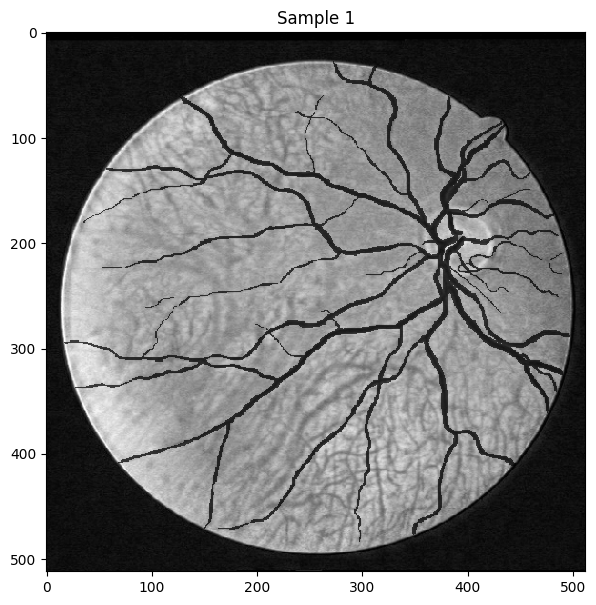

In [9]:
for i in range(1):
    visualize_vessel_sample(train_dataset[i], title=f"Sample {i+1}")

In [10]:
for batch_data in train_dataloader:
    print("Image shape:", batch_data["img"].shape)  # Expected: [batch_size, 1, 512, 512]
    break

Image shape: torch.Size([4, 1, 512, 512])


# Models

In [11]:
# Setting up the neural network
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'The used device is {device}')

The used device is cuda


In [12]:
models = build_ensemble_models(config, device)
print(f"Loaded {len(models)} models: {[type(m).__name__ for m in models]}")

Loaded 2 models: ['SwinUNETR', 'UNetWithDropout']


# Training

In [13]:
import torch
import wandb
from tqdm import tqdm
from monai.metrics import DiceMetric
from monai.transforms import AsDiscrete
from regularization import *
import monai

import torch.nn.functional as F

def masked_loss(pred, target, valid_mask, criterion):##torch.nn.BCEWithLogitsLoss(reduction='none')):
    loss_map = criterion(pred, target)
    masked_loss = loss_map * valid_mask
    return masked_loss.sum() / valid_mask.sum()


def train(model, epochs, train_dataloader, validation_loader, optimizer,loss_function,n,early_stopping, device):
    dice_metric = DiceMetric(include_background=True, reduction="mean", get_not_nans=False)
    post_pred = AsDiscrete(threshold=0.5)
    post_label = AsDiscrete(threshold=0.5)
    
    best_val_loss = float("inf")
    best_model_path = f"{config['save_model']}/{model.__class__.__name__}_best.pt"

    for epoch in tqdm(range(epochs), desc="Epochs"):
        model.train()    
        epoch_loss = 0.0
        step = 0

        for batch_data in train_dataloader:
            step += 1
            optimizer.zero_grad()

            imgs = batch_data["img"].float().to(device)
            masks = batch_data["mask"].float().to(device)
            if "valid_mask" in batch_data:
                valid_mask = batch_data["valid_mask"].float().to(device)
            else:
                valid_mask = torch.ones_like(batch_data["mask"]).float().to(device)

            preds = model(imgs)

            # Use masked loss
            criterion = create_loss(config)
            loss = masked_loss(preds, masks, valid_mask, criterion)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        train_loss = epoch_loss / step
        print(f"Epoch [{epoch+1}/{epochs}], Avg Loss: {train_loss:.4f}")

        # ----- VALIDATION -----
        step = 0
        val_loss = 0
        correct_pixels = 0
        total_pixels = 0

        dice_metric.reset()
        model.eval()
        with torch.no_grad():
            for batch_data in validation_loader:
                step += 1

                imgs = batch_data["img"].float().to(device)
                masks = batch_data["mask"].float().to(device)

                if "valid_mask" in batch_data:
                    valid_mask = batch_data["valid_mask"].float().to(device)
                else:
                    valid_mask = torch.ones_like(masks).float().to(device)

                # Forward pass
                outputs = model(imgs)

                # Compute masked loss
                loss = masked_loss(outputs, masks, valid_mask,criterion)
                val_loss += loss.item()

                # Apply sigmoid and threshold
                preds = torch.sigmoid(outputs) > 0.5

                # Apply valid mask for accuracy and Dice
                masked_preds = preds.float() * valid_mask
                masked_targets = masks * valid_mask

                # Accuracy
                correct_pixels += (masked_preds == masked_targets).sum().item()
                total_pixels += valid_mask.sum().item()  # Count only valid pixels

                # Dice Score
                dice_metric(masked_preds, masked_targets)

            val_loss = val_loss / step
            accuracy = correct_pixels / total_pixels
            mean_dice = dice_metric.aggregate().item()
            dice_metric.reset()  
            
            log_to_wandb(epoch, train_loss, val_loss, accuracy, mean_dice, batch_data, outputs)

            # Check if this is the best model so far
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                torch.save(model.state_dict(), best_model_path)
                print(f"✅ Best model saved at epoch {epoch+1} with val_loss: {val_loss:.4f}")

            # Early stopping (if past warmup)
            if epoch >= 40:
                early_stopping(val_loss)
                if early_stopping.early_stop:
                    print("🛑 Early stopping triggered.")
                    break
                    
def log_to_wandb(epoch, train_loss, val_loss, accuracy, mean_dice, batch_data, outputs):
    """Logs metrics and image/mask visualizations to Weights & Biases."""
    
    imgs = batch_data['img'].detach().cpu()
    masks = batch_data['mask'].detach().cpu()
    preds = outputs.detach().cpu()

    # Optional valid_mask
    valid_mask = batch_data.get('valid_mask', None)
    if valid_mask is not None:
        valid_mask = valid_mask.detach().cpu()
    else:
        valid_mask = torch.ones_like(masks)  # fallback to all-valid

    log_imgs = []
    for img, pred, gt, vmask in zip(imgs, preds, masks, valid_mask):
        # Apply sigmoid to raw logits and binarize
        pred = torch.sigmoid(pred)
        pred_bin = torch.round(pred) * vmask  # apply valid mask
        gt_bin = gt * vmask

        # Log image with overlaid predictions and ground truth
        log_imgs.append(wandb.Image(img.squeeze(), masks=wandb_masks(pred_bin, gt_bin)))

    # Log everything
    wandb.log({
        'epoch': epoch,
        'train_loss': train_loss,
        'val_loss': val_loss,
        'pixelaccuracy': accuracy,
        'mean_dice': mean_dice,
        'results': log_imgs
    })
    


def wandb_masks(mask_output, mask_gt):
    """Creates a dictionary of masks formatted for WandB image overlay."""
    class_labels = {1: 'vessels'}

    return {
        'predictions': {'mask_data': mask_output.squeeze().numpy(), 'class_labels': class_labels},
        'ground truth': {'mask_data': mask_gt.squeeze().numpy(), 'class_labels': class_labels}
    }


In [14]:
def from_compose_to_list(transform):
    return transform.transforms

torch.manual_seed(42)
np.random.seed(42)
import random 
random.seed(42)

torch.cuda.empty_cache()

# defining the dictionary mapping each model to its Dice coefficient for l;ater computation
model_dice_dict = {}

for model in models:
    ##wandb.finish()  # ensures a clean slate

    print(f"Starting model: {model.__class__.__name__}")
    n = sum(p.numel() for p in model.parameters() if p.requires_grad) # number of parameters
    early_stopping = EarlyStopping(patience=config['early_stopping_patience'], delta=0.001)

    loss_function = create_loss(config)
    
    optimizer = create_optimizer(config, model)
    
    now = datetime.now()
    now_str = now.strftime("%Y-%m-%d_%H-%M-%S")
    print(now_str)

    run = wandb.init(
        project='DRIVE',
        name=now_str,
        config={
            #'models': str([type(m).__name__ for m in models]),
            'loss function': str(loss_function), 
            'lr': optimizer.param_groups[0]["lr"],
            'transform': from_compose_to_list(train_transforms),
            'batch_size': train_dataloader.batch_size,
            'layers': 5,
            'parameters': n,
            'early_stopping_patience': str(config['early_stopping_patience'])    
        }
    )
    wandb.config.update(config)
    run_id = run.id # We remember here the run ID to be able to write the evaluation metrics

    ### training loop
    epochs = n_epochs
    train(model, epochs, train_dataloader, validation_loader, optimizer,loss_function,n,early_stopping, device)
    
    # Store the network parameters   
    os.makedirs(config['save_model'], exist_ok=True)
    torch.save(model.state_dict(), f"{config['save_model']}/{model.__class__.__name__}.pt")
    print(f"Model saved to {config['save_model']}")
    run.finish()
    
    api = wandb.Api()
    run = api.run(f"DRIVE/{run_id}")
    
    # Final Dice
    metric_fn = monai.metrics.DiceMetric()
    dice = compute_metric(validation_loader, model, metric_fn,device)
    run.summary["dice"] = dice
    run.summary.update()
    print(f"Dice on validation set: {dice:.3f}")

    model_dice_dict[model] = dice
    
    # Final Hausdorff distance
    metric_fn = monai.metrics.HausdorffDistanceMetric()
    HausdorffDistance = compute_metric(validation_loader, model, metric_fn,device)
    run.summary["HausdorffDistance"] = HausdorffDistance
    run.summary.update()
    print(f"HausdorffDistance on validation set: {HausdorffDistance:.3f}")

Starting model: SwinUNETR
2025-04-04_12-18-14


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: martidan182 (martidan182-university-of-twente) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epochs:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch [1/250], Avg Loss: 0.7379


Epochs:   0%|          | 1/250 [00:13<55:31, 13.38s/it]

✅ Best model saved at epoch 1 with val_loss: 0.6624
Epoch [2/250], Avg Loss: 0.6180


Epochs:   1%|          | 2/250 [00:22<44:22, 10.74s/it]

✅ Best model saved at epoch 2 with val_loss: 0.5992
Epoch [3/250], Avg Loss: 0.5642


Epochs:   1%|          | 3/250 [00:31<40:42,  9.89s/it]

✅ Best model saved at epoch 3 with val_loss: 0.5579
Epoch [4/250], Avg Loss: 0.5282


Epochs:   2%|▏         | 4/250 [00:40<38:55,  9.49s/it]

✅ Best model saved at epoch 4 with val_loss: 0.5264
Epoch [5/250], Avg Loss: 0.4984


Epochs:   2%|▏         | 5/250 [00:49<38:56,  9.54s/it]

✅ Best model saved at epoch 5 with val_loss: 0.4983
Epoch [6/250], Avg Loss: 0.4715


Epochs:   2%|▏         | 6/250 [00:59<38:38,  9.50s/it]

✅ Best model saved at epoch 6 with val_loss: 0.4777
Epoch [7/250], Avg Loss: 0.4533


Epochs:   3%|▎         | 7/250 [01:08<37:43,  9.31s/it]

✅ Best model saved at epoch 7 with val_loss: 0.4679
Epoch [8/250], Avg Loss: 0.4322


Epochs:   3%|▎         | 8/250 [01:16<37:02,  9.18s/it]

✅ Best model saved at epoch 8 with val_loss: 0.4375
Epoch [9/250], Avg Loss: 0.4152


Epochs:   4%|▎         | 9/250 [01:25<36:31,  9.09s/it]

✅ Best model saved at epoch 9 with val_loss: 0.4281
Epoch [10/250], Avg Loss: 0.3988


Epochs:   4%|▍         | 10/250 [01:35<36:41,  9.17s/it]

✅ Best model saved at epoch 10 with val_loss: 0.4034
Epoch [11/250], Avg Loss: 0.3870


Epochs:   4%|▍         | 11/250 [01:44<37:13,  9.35s/it]

✅ Best model saved at epoch 11 with val_loss: 0.3956
Epoch [12/250], Avg Loss: 0.3728


Epochs:   5%|▍         | 12/250 [01:53<36:30,  9.20s/it]

✅ Best model saved at epoch 12 with val_loss: 0.3823
Epoch [13/250], Avg Loss: 0.3602


Epochs:   5%|▌         | 13/250 [02:02<35:57,  9.10s/it]

✅ Best model saved at epoch 13 with val_loss: 0.3636
Epoch [14/250], Avg Loss: 0.3482


Epochs:   6%|▌         | 14/250 [02:11<35:44,  9.09s/it]

✅ Best model saved at epoch 14 with val_loss: 0.3601
Epoch [15/250], Avg Loss: 0.3388


Epochs:   6%|▌         | 15/250 [02:20<35:25,  9.04s/it]

✅ Best model saved at epoch 15 with val_loss: 0.3600
Epoch [16/250], Avg Loss: 0.3285


Epochs:   6%|▋         | 16/250 [02:30<36:02,  9.24s/it]

✅ Best model saved at epoch 16 with val_loss: 0.3349
Epoch [17/250], Avg Loss: 0.3176


Epochs:   7%|▋         | 17/250 [02:39<36:00,  9.27s/it]

Epoch [18/250], Avg Loss: 0.3101


Epochs:   7%|▋         | 18/250 [02:48<35:30,  9.18s/it]

✅ Best model saved at epoch 18 with val_loss: 0.3213
Epoch [19/250], Avg Loss: 0.3038


Epochs:   8%|▊         | 19/250 [02:57<35:01,  9.10s/it]

✅ Best model saved at epoch 19 with val_loss: 0.3172
Epoch [20/250], Avg Loss: 0.2967


Epochs:   8%|▊         | 20/250 [03:06<34:42,  9.05s/it]

✅ Best model saved at epoch 20 with val_loss: 0.3089
Epoch [21/250], Avg Loss: 0.2901


Epochs:   8%|▊         | 21/250 [03:15<34:48,  9.12s/it]

✅ Best model saved at epoch 21 with val_loss: 0.3084
Epoch [22/250], Avg Loss: 0.2824


Epochs:   9%|▉         | 22/250 [03:25<35:23,  9.31s/it]

✅ Best model saved at epoch 22 with val_loss: 0.2938
Epoch [23/250], Avg Loss: 0.2775


Epochs:   9%|▉         | 23/250 [03:34<34:51,  9.21s/it]

✅ Best model saved at epoch 23 with val_loss: 0.2918
Epoch [24/250], Avg Loss: 0.2747


Epochs:  10%|▉         | 24/250 [03:43<34:27,  9.15s/it]

✅ Best model saved at epoch 24 with val_loss: 0.2845
Epoch [25/250], Avg Loss: 0.2699


Epochs:  10%|█         | 25/250 [03:52<33:46,  9.01s/it]

Epoch [26/250], Avg Loss: 0.2667


Epochs:  10%|█         | 26/250 [04:02<34:38,  9.28s/it]

✅ Best model saved at epoch 26 with val_loss: 0.2815
Epoch [27/250], Avg Loss: 0.2674


Epochs:  11%|█         | 27/250 [04:11<34:54,  9.39s/it]

✅ Best model saved at epoch 27 with val_loss: 0.2781
Epoch [28/250], Avg Loss: 0.2600


Epochs:  11%|█         | 28/250 [04:21<34:49,  9.41s/it]

✅ Best model saved at epoch 28 with val_loss: 0.2755
Epoch [29/250], Avg Loss: 0.2564


Epochs:  12%|█▏        | 29/250 [04:29<33:52,  9.20s/it]

Epoch [30/250], Avg Loss: 0.2554


Epochs:  12%|█▏        | 30/250 [04:38<33:22,  9.10s/it]

✅ Best model saved at epoch 30 with val_loss: 0.2668
Epoch [31/250], Avg Loss: 0.2507


Epochs:  12%|█▏        | 31/250 [04:47<32:43,  8.97s/it]

Epoch [32/250], Avg Loss: 0.2464


Epochs:  13%|█▎        | 32/250 [04:56<32:35,  8.97s/it]

✅ Best model saved at epoch 32 with val_loss: 0.2618
Epoch [33/250], Avg Loss: 0.2435


Epochs:  13%|█▎        | 33/250 [05:05<32:53,  9.09s/it]

Epoch [34/250], Avg Loss: 0.2376


Epochs:  14%|█▎        | 34/250 [05:14<32:47,  9.11s/it]

Epoch [35/250], Avg Loss: 0.2353


Epochs:  14%|█▍        | 35/250 [05:23<32:19,  9.02s/it]

Epoch [36/250], Avg Loss: 0.2336


Epochs:  14%|█▍        | 36/250 [05:32<31:45,  8.91s/it]

Epoch [37/250], Avg Loss: 0.2303


Epochs:  15%|█▍        | 37/250 [05:41<31:34,  8.89s/it]

✅ Best model saved at epoch 37 with val_loss: 0.2554
Epoch [38/250], Avg Loss: 0.2252


Epochs:  15%|█▌        | 38/250 [05:50<31:27,  8.90s/it]

✅ Best model saved at epoch 38 with val_loss: 0.2542
Epoch [39/250], Avg Loss: 0.2213


Epochs:  16%|█▌        | 39/250 [05:59<31:43,  9.02s/it]

Epoch [40/250], Avg Loss: 0.2185


Epochs:  16%|█▌        | 40/250 [06:08<31:39,  9.04s/it]

Epoch [41/250], Avg Loss: 0.2181


Epochs:  16%|█▋        | 41/250 [06:17<31:03,  8.92s/it]

Epoch [42/250], Avg Loss: 0.2165


Epochs:  17%|█▋        | 42/250 [06:25<30:40,  8.85s/it]

EarlyStopping counter: 1 / 10
Epoch [43/250], Avg Loss: 0.2159


Epochs:  17%|█▋        | 43/250 [06:34<30:18,  8.79s/it]

EarlyStopping counter: 2 / 10
Epoch [44/250], Avg Loss: 0.2156


Epochs:  18%|█▊        | 44/250 [06:43<30:22,  8.85s/it]

✅ Best model saved at epoch 44 with val_loss: 0.2467
Epoch [45/250], Avg Loss: 0.2116


Epochs:  18%|█▊        | 45/250 [06:52<30:44,  9.00s/it]

EarlyStopping counter: 1 / 10
Epoch [46/250], Avg Loss: 0.2066


Epochs:  18%|█▊        | 46/250 [07:02<30:51,  9.08s/it]

EarlyStopping counter: 2 / 10
Epoch [47/250], Avg Loss: 0.2028


Epochs:  19%|█▉        | 47/250 [07:10<30:16,  8.95s/it]

EarlyStopping counter: 3 / 10
Epoch [48/250], Avg Loss: 0.1985


Epochs:  19%|█▉        | 48/250 [07:19<29:47,  8.85s/it]

EarlyStopping counter: 4 / 10
Epoch [49/250], Avg Loss: 0.1972


Epochs:  20%|█▉        | 49/250 [07:28<29:38,  8.85s/it]

✅ Best model saved at epoch 49 with val_loss: 0.2453
Epoch [50/250], Avg Loss: 0.1926


Epochs:  20%|██        | 50/250 [07:36<29:18,  8.79s/it]

EarlyStopping counter: 1 / 10
Epoch [51/250], Avg Loss: 0.1899


Epochs:  20%|██        | 51/250 [07:46<29:41,  8.95s/it]

EarlyStopping counter: 2 / 10
Epoch [52/250], Avg Loss: 0.1873


Epochs:  21%|██        | 52/250 [07:55<29:55,  9.07s/it]

EarlyStopping counter: 3 / 10
Epoch [53/250], Avg Loss: 0.1871


Epochs:  21%|██        | 53/250 [08:04<29:20,  8.94s/it]

EarlyStopping counter: 4 / 10
Epoch [54/250], Avg Loss: 0.1957


Epochs:  22%|██▏       | 54/250 [08:12<28:54,  8.85s/it]

EarlyStopping counter: 5 / 10
Epoch [55/250], Avg Loss: 0.1942


Epochs:  22%|██▏       | 55/250 [08:21<28:32,  8.78s/it]

EarlyStopping counter: 6 / 10
Epoch [56/250], Avg Loss: 0.1964


Epochs:  22%|██▏       | 56/250 [08:30<28:29,  8.81s/it]

✅ Best model saved at epoch 56 with val_loss: 0.2438
Epoch [57/250], Avg Loss: 0.1883


Epochs:  23%|██▎       | 57/250 [08:39<28:50,  8.97s/it]

EarlyStopping counter: 1 / 10
Epoch [58/250], Avg Loss: 0.1844


Epochs:  23%|██▎       | 58/250 [08:49<29:03,  9.08s/it]

EarlyStopping counter: 2 / 10
Epoch [59/250], Avg Loss: 0.1772


Epochs:  24%|██▎       | 59/250 [08:57<28:28,  8.95s/it]

EarlyStopping counter: 3 / 10
Epoch [60/250], Avg Loss: 0.1722


Epochs:  24%|██▍       | 60/250 [09:06<28:03,  8.86s/it]

EarlyStopping counter: 4 / 10
Epoch [61/250], Avg Loss: 0.1691


Epochs:  24%|██▍       | 61/250 [09:14<27:41,  8.79s/it]

EarlyStopping counter: 5 / 10
Epoch [62/250], Avg Loss: 0.1656


Epochs:  25%|██▍       | 62/250 [09:23<27:24,  8.75s/it]

EarlyStopping counter: 6 / 10
Epoch [63/250], Avg Loss: 0.1637


Epochs:  25%|██▌       | 63/250 [09:32<27:35,  8.85s/it]

EarlyStopping counter: 7 / 10
Epoch [64/250], Avg Loss: 0.1643


Epochs:  26%|██▌       | 64/250 [09:42<27:54,  9.00s/it]

EarlyStopping counter: 8 / 10
Epoch [65/250], Avg Loss: 0.1643


Epochs:  26%|██▌       | 65/250 [09:51<27:49,  9.02s/it]

✅ Best model saved at epoch 65 with val_loss: 0.2393
Epoch [66/250], Avg Loss: 0.1608


Epochs:  26%|██▋       | 66/250 [10:00<27:36,  9.00s/it]

EarlyStopping counter: 1 / 10
Epoch [67/250], Avg Loss: 0.1559


Epochs:  27%|██▋       | 67/250 [10:08<27:11,  8.92s/it]

EarlyStopping counter: 2 / 10
Epoch [68/250], Avg Loss: 0.1533


Epochs:  27%|██▋       | 68/250 [10:17<26:46,  8.83s/it]

EarlyStopping counter: 3 / 10
Epoch [69/250], Avg Loss: 0.1499


Epochs:  28%|██▊       | 69/250 [10:26<26:48,  8.89s/it]

EarlyStopping counter: 4 / 10
Epoch [70/250], Avg Loss: 0.1467


Epochs:  28%|██▊       | 70/250 [10:35<27:07,  9.04s/it]

EarlyStopping counter: 5 / 10
Epoch [71/250], Avg Loss: 0.1438


Epochs:  28%|██▊       | 71/250 [10:44<26:47,  8.98s/it]

EarlyStopping counter: 6 / 10
Epoch [72/250], Avg Loss: 0.1407


Epochs:  29%|██▉       | 72/250 [10:53<26:23,  8.89s/it]

EarlyStopping counter: 7 / 10
Epoch [73/250], Avg Loss: 0.1380


Epochs:  29%|██▉       | 73/250 [11:02<26:02,  8.83s/it]

EarlyStopping counter: 8 / 10
Epoch [74/250], Avg Loss: 0.1367


Epochs:  30%|██▉       | 74/250 [11:10<25:46,  8.78s/it]

EarlyStopping counter: 9 / 10
Epoch [75/250], Avg Loss: 0.1368


Epochs:  30%|██▉       | 74/250 [11:19<26:56,  9.18s/it]

EarlyStopping counter: 10 / 10
🛑 Early stopping triggered.


Model saved to ../saved_models/


epoch,▁▁▁▁▁▂▂▂▂▂▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇█████
mean_dice,▁▆▆▆▇▇▇▇█▇▇█████▇███████████████████████
pixelaccuracy,▁▅▅▅▆▇▇▆▇▇▇████▇█▇█▇████████████████████
train_loss,█▆▆▅▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
val_loss,█▇▇▆▅▄▄▃▃▃▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁
epoch,74
mean_dice,0.76426
pixelaccuracy,1.39853
train_loss,0.13677
val_loss,0.24554


Dice on validation set: 0.724
HausdorffDistance on validation set: 33.771
Starting model: UNetWithDropout
2025-04-04_12-29-47


Epochs:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch [1/250], Avg Loss: 0.8123


Epochs:   0%|          | 1/250 [00:03<15:16,  3.68s/it]

✅ Best model saved at epoch 1 with val_loss: 0.8603
Epoch [2/250], Avg Loss: 0.7528


Epochs:   1%|          | 2/250 [00:06<12:15,  2.96s/it]

Epoch [3/250], Avg Loss: 0.7391


Epochs:   1%|          | 3/250 [00:08<11:19,  2.75s/it]

Epoch [4/250], Avg Loss: 0.7217


Epochs:   2%|▏         | 4/250 [00:11<11:06,  2.71s/it]

✅ Best model saved at epoch 4 with val_loss: 0.8597
Epoch [5/250], Avg Loss: 0.7156


Epochs:   2%|▏         | 5/250 [00:14<11:04,  2.71s/it]

✅ Best model saved at epoch 5 with val_loss: 0.8577
Epoch [6/250], Avg Loss: 0.7049


Epochs:   2%|▏         | 6/250 [00:16<11:03,  2.72s/it]

✅ Best model saved at epoch 6 with val_loss: 0.8421
Epoch [7/250], Avg Loss: 0.7064


Epochs:   3%|▎         | 7/250 [00:19<11:12,  2.77s/it]

Epoch [8/250], Avg Loss: 0.7053


Epochs:   3%|▎         | 8/250 [00:22<10:52,  2.70s/it]

✅ Best model saved at epoch 8 with val_loss: 0.8347
Epoch [9/250], Avg Loss: 0.6886


Epochs:   4%|▎         | 9/250 [00:24<10:33,  2.63s/it]

✅ Best model saved at epoch 9 with val_loss: 0.7842
Epoch [10/250], Avg Loss: 0.6842


Epochs:   4%|▍         | 10/250 [00:27<10:40,  2.67s/it]

✅ Best model saved at epoch 10 with val_loss: 0.7669
Epoch [11/250], Avg Loss: 0.6738


Epochs:   4%|▍         | 11/250 [00:30<10:37,  2.67s/it]

✅ Best model saved at epoch 11 with val_loss: 0.7130
Epoch [12/250], Avg Loss: 0.6788


Epochs:   5%|▍         | 12/250 [00:32<10:46,  2.71s/it]

✅ Best model saved at epoch 12 with val_loss: 0.7098
Epoch [13/250], Avg Loss: 0.6733


Epochs:   5%|▌         | 13/250 [00:35<10:49,  2.74s/it]

✅ Best model saved at epoch 13 with val_loss: 0.6856
Epoch [14/250], Avg Loss: 0.6562


Epochs:   6%|▌         | 14/250 [00:38<10:57,  2.78s/it]

✅ Best model saved at epoch 14 with val_loss: 0.6749
Epoch [15/250], Avg Loss: 0.6609


Epochs:   6%|▌         | 15/250 [00:41<10:44,  2.74s/it]

✅ Best model saved at epoch 15 with val_loss: 0.6650
Epoch [16/250], Avg Loss: 0.6406


Epochs:   6%|▋         | 16/250 [00:43<10:35,  2.72s/it]

✅ Best model saved at epoch 16 with val_loss: 0.6412
Epoch [17/250], Avg Loss: 0.6467


Epochs:   7%|▋         | 17/250 [00:46<10:27,  2.69s/it]

✅ Best model saved at epoch 17 with val_loss: 0.6292
Epoch [18/250], Avg Loss: 0.6391


Epochs:   7%|▋         | 18/250 [00:49<10:13,  2.65s/it]

✅ Best model saved at epoch 18 with val_loss: 0.6285
Epoch [19/250], Avg Loss: 0.6151


Epochs:   8%|▊         | 19/250 [00:51<09:54,  2.58s/it]

Epoch [20/250], Avg Loss: 0.6286


Epochs:   8%|▊         | 20/250 [00:53<09:40,  2.52s/it]

Epoch [21/250], Avg Loss: 0.6339


Epochs:   8%|▊         | 21/250 [00:56<09:36,  2.52s/it]

✅ Best model saved at epoch 21 with val_loss: 0.6202
Epoch [22/250], Avg Loss: 0.6249


Epochs:   9%|▉         | 22/250 [00:58<09:34,  2.52s/it]

✅ Best model saved at epoch 22 with val_loss: 0.6064
Epoch [23/250], Avg Loss: 0.6264


Epochs:   9%|▉         | 23/250 [01:01<09:40,  2.56s/it]

Epoch [24/250], Avg Loss: 0.5827


Epochs:  10%|▉         | 24/250 [01:04<09:58,  2.65s/it]

✅ Best model saved at epoch 24 with val_loss: 0.6008
Epoch [25/250], Avg Loss: 0.5698


Epochs:  10%|█         | 25/250 [01:07<10:11,  2.72s/it]

Epoch [26/250], Avg Loss: 0.5862


Epochs:  10%|█         | 26/250 [01:09<10:09,  2.72s/it]

Epoch [27/250], Avg Loss: 0.5873


Epochs:  11%|█         | 27/250 [01:12<10:21,  2.79s/it]

✅ Best model saved at epoch 27 with val_loss: 0.5782
Epoch [28/250], Avg Loss: 0.5866


Epochs:  11%|█         | 28/250 [01:15<09:57,  2.69s/it]

✅ Best model saved at epoch 28 with val_loss: 0.5557
Epoch [29/250], Avg Loss: 0.5748


Epochs:  12%|█▏        | 29/250 [01:17<09:39,  2.62s/it]

✅ Best model saved at epoch 29 with val_loss: 0.5431
Epoch [30/250], Avg Loss: 0.5432


Epochs:  12%|█▏        | 30/250 [01:20<09:28,  2.58s/it]

✅ Best model saved at epoch 30 with val_loss: 0.5390
Epoch [31/250], Avg Loss: 0.5491


Epochs:  12%|█▏        | 31/250 [01:22<09:14,  2.53s/it]

Epoch [32/250], Avg Loss: 0.5469


Epochs:  13%|█▎        | 32/250 [01:25<09:03,  2.49s/it]

Epoch [33/250], Avg Loss: 0.5141


Epochs:  13%|█▎        | 33/250 [01:27<09:05,  2.51s/it]

Epoch [34/250], Avg Loss: 0.5125


Epochs:  14%|█▎        | 34/250 [01:30<09:06,  2.53s/it]

Epoch [35/250], Avg Loss: 0.5446


Epochs:  14%|█▍        | 35/250 [01:32<09:05,  2.54s/it]

Epoch [36/250], Avg Loss: 0.5246


Epochs:  14%|█▍        | 36/250 [01:35<08:55,  2.50s/it]

Epoch [37/250], Avg Loss: 0.5167


Epochs:  15%|█▍        | 37/250 [01:38<09:13,  2.60s/it]

Epoch [38/250], Avg Loss: 0.4965


Epochs:  15%|█▌        | 38/250 [01:40<09:20,  2.64s/it]

✅ Best model saved at epoch 38 with val_loss: 0.5054
Epoch [39/250], Avg Loss: 0.5042


Epochs:  16%|█▌        | 39/250 [01:43<09:12,  2.62s/it]

✅ Best model saved at epoch 39 with val_loss: 0.5042
Epoch [40/250], Avg Loss: 0.4764


Epochs:  16%|█▌        | 40/250 [01:46<09:21,  2.67s/it]

✅ Best model saved at epoch 40 with val_loss: 0.4741
Epoch [41/250], Avg Loss: 0.4618


Epochs:  16%|█▋        | 41/250 [01:48<09:05,  2.61s/it]

Epoch [42/250], Avg Loss: 0.5042


Epochs:  17%|█▋        | 42/250 [01:51<08:53,  2.56s/it]

EarlyStopping counter: 1 / 10
Epoch [43/250], Avg Loss: 0.4830


Epochs:  17%|█▋        | 43/250 [01:54<09:12,  2.67s/it]

EarlyStopping counter: 2 / 10
Epoch [44/250], Avg Loss: 0.4567


Epochs:  18%|█▊        | 44/250 [01:56<09:11,  2.68s/it]

EarlyStopping counter: 3 / 10
Epoch [45/250], Avg Loss: 0.4385


Epochs:  18%|█▊        | 45/250 [01:59<09:06,  2.67s/it]

✅ Best model saved at epoch 45 with val_loss: 0.4672
Epoch [46/250], Avg Loss: 0.4365


Epochs:  18%|█▊        | 46/250 [02:02<09:04,  2.67s/it]

✅ Best model saved at epoch 46 with val_loss: 0.4501
Epoch [47/250], Avg Loss: 0.4352


Epochs:  19%|█▉        | 47/250 [02:04<08:51,  2.62s/it]

✅ Best model saved at epoch 47 with val_loss: 0.4171
Epoch [48/250], Avg Loss: 0.4219


Epochs:  19%|█▉        | 48/250 [02:07<08:43,  2.59s/it]

✅ Best model saved at epoch 48 with val_loss: 0.4160
Epoch [49/250], Avg Loss: 0.4084


Epochs:  20%|█▉        | 49/250 [02:09<08:30,  2.54s/it]

EarlyStopping counter: 1 / 10
Epoch [50/250], Avg Loss: 0.4349


Epochs:  20%|██        | 50/250 [02:11<08:22,  2.51s/it]

EarlyStopping counter: 2 / 10
Epoch [51/250], Avg Loss: 0.4306


Epochs:  20%|██        | 51/250 [02:14<08:16,  2.49s/it]

EarlyStopping counter: 3 / 10
Epoch [52/250], Avg Loss: 0.4133


Epochs:  21%|██        | 52/250 [02:16<08:14,  2.50s/it]

EarlyStopping counter: 4 / 10
Epoch [53/250], Avg Loss: 0.4033


Epochs:  21%|██        | 53/250 [02:19<08:39,  2.63s/it]

EarlyStopping counter: 5 / 10
Epoch [54/250], Avg Loss: 0.3908


Epochs:  22%|██▏       | 54/250 [02:22<08:58,  2.75s/it]

✅ Best model saved at epoch 54 with val_loss: 0.3813
Epoch [55/250], Avg Loss: 0.4104


Epochs:  22%|██▏       | 55/250 [02:25<09:03,  2.79s/it]

✅ Best model saved at epoch 55 with val_loss: 0.3699
Epoch [56/250], Avg Loss: 0.3826


Epochs:  22%|██▏       | 56/250 [02:28<08:46,  2.72s/it]

EarlyStopping counter: 1 / 10
Epoch [57/250], Avg Loss: 0.4016


Epochs:  23%|██▎       | 57/250 [02:30<08:26,  2.62s/it]

EarlyStopping counter: 2 / 10
Epoch [58/250], Avg Loss: 0.3637


Epochs:  23%|██▎       | 58/250 [02:33<08:12,  2.56s/it]

EarlyStopping counter: 3 / 10
Epoch [59/250], Avg Loss: 0.4246


Epochs:  24%|██▎       | 59/250 [02:35<08:02,  2.52s/it]

EarlyStopping counter: 4 / 10
Epoch [60/250], Avg Loss: 0.3576


Epochs:  24%|██▍       | 60/250 [02:38<07:57,  2.52s/it]

✅ Best model saved at epoch 60 with val_loss: 0.3697
EarlyStopping counter: 5 / 10
Epoch [61/250], Avg Loss: 0.3613


Epochs:  24%|██▍       | 61/250 [02:40<07:53,  2.51s/it]

✅ Best model saved at epoch 61 with val_loss: 0.3423
Epoch [62/250], Avg Loss: 0.3911


Epochs:  25%|██▍       | 62/250 [02:42<07:46,  2.48s/it]

EarlyStopping counter: 1 / 10
Epoch [63/250], Avg Loss: 0.3413


Epochs:  25%|██▌       | 63/250 [02:45<07:54,  2.54s/it]

✅ Best model saved at epoch 63 with val_loss: 0.3339
Epoch [64/250], Avg Loss: 0.3797


Epochs:  26%|██▌       | 64/250 [02:48<07:59,  2.58s/it]

EarlyStopping counter: 1 / 10
Epoch [65/250], Avg Loss: 0.3484


Epochs:  26%|██▌       | 65/250 [02:51<08:05,  2.63s/it]

✅ Best model saved at epoch 65 with val_loss: 0.3334
EarlyStopping counter: 2 / 10
Epoch [66/250], Avg Loss: 0.3663


Epochs:  26%|██▋       | 66/250 [02:53<08:00,  2.61s/it]

EarlyStopping counter: 3 / 10
Epoch [67/250], Avg Loss: 0.3696


Epochs:  27%|██▋       | 67/250 [02:56<07:54,  2.59s/it]

EarlyStopping counter: 4 / 10
Epoch [68/250], Avg Loss: 0.3289


Epochs:  27%|██▋       | 68/250 [02:58<07:45,  2.56s/it]

EarlyStopping counter: 5 / 10
Epoch [69/250], Avg Loss: 0.3299


Epochs:  28%|██▊       | 69/250 [03:01<08:23,  2.78s/it]

✅ Best model saved at epoch 69 with val_loss: 0.3155
Epoch [70/250], Avg Loss: 0.3549


Epochs:  28%|██▊       | 70/250 [03:05<08:54,  2.97s/it]

EarlyStopping counter: 1 / 10
Epoch [71/250], Avg Loss: 0.3304


Epochs:  28%|██▊       | 71/250 [03:07<08:25,  2.82s/it]

EarlyStopping counter: 2 / 10
Epoch [72/250], Avg Loss: 0.3305


Epochs:  29%|██▉       | 72/250 [03:10<08:29,  2.86s/it]

EarlyStopping counter: 3 / 10
Epoch [73/250], Avg Loss: 0.3483


Epochs:  29%|██▉       | 73/250 [03:13<08:13,  2.79s/it]

EarlyStopping counter: 4 / 10
Epoch [74/250], Avg Loss: 0.3408


Epochs:  30%|██▉       | 74/250 [03:16<08:06,  2.76s/it]

EarlyStopping counter: 5 / 10
Epoch [75/250], Avg Loss: 0.3270


Epochs:  30%|███       | 75/250 [03:18<07:52,  2.70s/it]

✅ Best model saved at epoch 75 with val_loss: 0.3028
Epoch [76/250], Avg Loss: 0.3146


Epochs:  30%|███       | 76/250 [03:21<07:41,  2.66s/it]

✅ Best model saved at epoch 76 with val_loss: 0.2953
Epoch [77/250], Avg Loss: 0.3105


Epochs:  31%|███       | 77/250 [03:23<07:32,  2.62s/it]

✅ Best model saved at epoch 77 with val_loss: 0.2847
Epoch [78/250], Avg Loss: 0.2867


Epochs:  31%|███       | 78/250 [03:26<07:25,  2.59s/it]

✅ Best model saved at epoch 78 with val_loss: 0.2759
Epoch [79/250], Avg Loss: 0.3131


Epochs:  32%|███▏      | 79/250 [03:28<07:15,  2.55s/it]

EarlyStopping counter: 1 / 10
Epoch [80/250], Avg Loss: 0.3084


Epochs:  32%|███▏      | 80/250 [03:31<07:09,  2.52s/it]

EarlyStopping counter: 2 / 10
Epoch [81/250], Avg Loss: 0.2977


Epochs:  32%|███▏      | 81/250 [03:33<07:03,  2.50s/it]

EarlyStopping counter: 3 / 10
Epoch [82/250], Avg Loss: 0.3097


Epochs:  33%|███▎      | 82/250 [03:36<07:06,  2.54s/it]

EarlyStopping counter: 4 / 10
Epoch [83/250], Avg Loss: 0.3073


Epochs:  33%|███▎      | 83/250 [03:38<07:06,  2.55s/it]

EarlyStopping counter: 5 / 10
Epoch [84/250], Avg Loss: 0.3088


Epochs:  34%|███▎      | 84/250 [03:41<07:06,  2.57s/it]

EarlyStopping counter: 6 / 10
Epoch [85/250], Avg Loss: 0.3005


Epochs:  34%|███▍      | 85/250 [03:43<06:57,  2.53s/it]

EarlyStopping counter: 7 / 10
Epoch [86/250], Avg Loss: 0.2747


Epochs:  34%|███▍      | 86/250 [03:46<06:57,  2.55s/it]

✅ Best model saved at epoch 86 with val_loss: 0.2716
Epoch [87/250], Avg Loss: 0.2581


Epochs:  35%|███▍      | 87/250 [03:49<06:55,  2.55s/it]

EarlyStopping counter: 1 / 10
Epoch [88/250], Avg Loss: 0.2851


Epochs:  35%|███▌      | 88/250 [03:51<06:55,  2.56s/it]

EarlyStopping counter: 2 / 10
Epoch [89/250], Avg Loss: 0.2843


Epochs:  36%|███▌      | 89/250 [03:54<06:46,  2.52s/it]

EarlyStopping counter: 3 / 10
Epoch [90/250], Avg Loss: 0.2934


Epochs:  36%|███▌      | 90/250 [03:56<06:38,  2.49s/it]

EarlyStopping counter: 4 / 10
Epoch [91/250], Avg Loss: 0.2936


Epochs:  36%|███▋      | 91/250 [03:58<06:32,  2.47s/it]

EarlyStopping counter: 5 / 10
Epoch [92/250], Avg Loss: 0.2698


Epochs:  37%|███▋      | 92/250 [04:01<06:35,  2.50s/it]

EarlyStopping counter: 6 / 10
Epoch [93/250], Avg Loss: 0.2828


Epochs:  37%|███▋      | 93/250 [04:04<06:37,  2.53s/it]

EarlyStopping counter: 7 / 10
Epoch [94/250], Avg Loss: 0.2879


Epochs:  38%|███▊      | 94/250 [04:06<06:39,  2.56s/it]

EarlyStopping counter: 8 / 10
Epoch [95/250], Avg Loss: 0.2514


Epochs:  38%|███▊      | 95/250 [04:09<06:42,  2.60s/it]

EarlyStopping counter: 9 / 10
Epoch [96/250], Avg Loss: 0.2629


Epochs:  38%|███▊      | 95/250 [04:11<06:50,  2.65s/it]

EarlyStopping counter: 10 / 10
🛑 Early stopping triggered.
Model saved to ../saved_models/


epoch,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
mean_dice,▁▂▂▆▆▇▆▇▇▇▇▇▇▇▆▇▇▇▇▇█▇▆▇████████████████
pixelaccuracy,▄▄▄▄▅▆▆▇▁▄▄▄▄▆▆▄▂▂▅▆▇▆▇██▇▇█▆▇███████▇▇▇
train_loss,█▇▇▇▇▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▂▁▁
val_loss,███▇▆▅▆▅▅▅▄▄▄▃▃▄▄▃▃▃▃▄▂▂▂▂▂▂▁▂▂▁▁▁▁▁▁▁▁▁
epoch,95
mean_dice,0.7522
pixelaccuracy,1.3876
train_loss,0.26287
val_loss,0.28433


Dice on validation set: 0.755
HausdorffDistance on validation set: 30.567


In [16]:
def evaluate_ensemble(models, val_loader, device):
    sigmoid = torch.nn.Sigmoid()
    threshold = 0.5
    dice_metric = monai.metrics.DiceMetric()

    for batch in val_loader:
        img = batch['img'].to(device)
        mask = batch['mask'].to(device)

        if img.dim() == 3:
            img = img.unsqueeze(0)

        # Ensemble prediction
        with torch.no_grad():
            preds = []
            for model in models:
                model.eval()
                out = model(img)
                probs = sigmoid(out)
                preds.append(probs.cpu())

            combined = torch.stack(preds).mean(dim=0)  # average strategy
            binarized = (combined > threshold).float().to(device)

        dice_metric(y_pred=binarized, y=mask)

    final_dice = dice_metric.aggregate().item()
    print(f"📊 Ensemble Dice Score: {final_dice:.4f}")
    
evaluate_ensemble(models, validation_loader, device)


📊 Ensemble Dice Score: 0.7796


# Test

In [20]:
def visual_evaluation_nomask_ensemble(sample, models, device, method='average'):
    """
    Visual evaluation with ensemble:
    - Supports 'average' or 'vote' ensemble strategies.
    - Displays input and combined prediction overlay.
    """
    sigmoid = torch.nn.Sigmoid()
    threshold = monai.transforms.AsDiscrete(threshold_values=True)

    img_tensor = sample['img'].float().to(device)
    if img_tensor.dim() == 3:
        img_tensor = img_tensor.unsqueeze(0)  # [1, 1, H, W]

    # Collect outputs from all models
    with torch.no_grad():
        preds = []
        for model in models:
            model.eval()
            output = model(img_tensor)
            probs = sigmoid(output)  # Probabilities
            preds.append(probs.cpu())

        # Combine ensemble predictions
        if method == 'average':
            combined = torch.stack(preds).mean(dim=0)  # [1, 1, H, W]
        elif method == 'vote':
            binarized = [threshold(p) for p in preds]
            combined = torch.stack(binarized).float().mean(dim=0)
            combined = (combined > 0.5).float()
        else:
            raise ValueError(f"Unsupported ensemble method: {method}")

        combined_np = threshold(combined).squeeze().numpy()  # Final binarized mask

    # Get original image
    img_np = sample['img'].squeeze().cpu().numpy()

    combined_np = (combined.squeeze().cpu().numpy() > 0.5).astype(np.uint8)
    overlay_mask = np.ma.masked_where(combined_np == 0, np.ones_like(combined_np))

    fig, ax = plt.subplots(1, 2, figsize=(14, 6))
    ax[0].imshow(img_np, cmap='gray')
    ax[0].set_title('Input Image')

    ax[1].imshow(img_np, cmap='gray')
    # Try a bright colormap
    ax[1].imshow(overlay_mask, cmap='autumn', alpha=0.8, interpolation='none')
    ax[1].set_title("Prediction Overlay")
    
    plt.savefig("test3_ensemble")
    plt.show()

Loading dataset: 100%|██████████| 20/20 [00:00<00:00, 131.56it/s]


Test Image dtype: torch.float32
Test Image shape: torch.Size([1, 1, 512, 512])


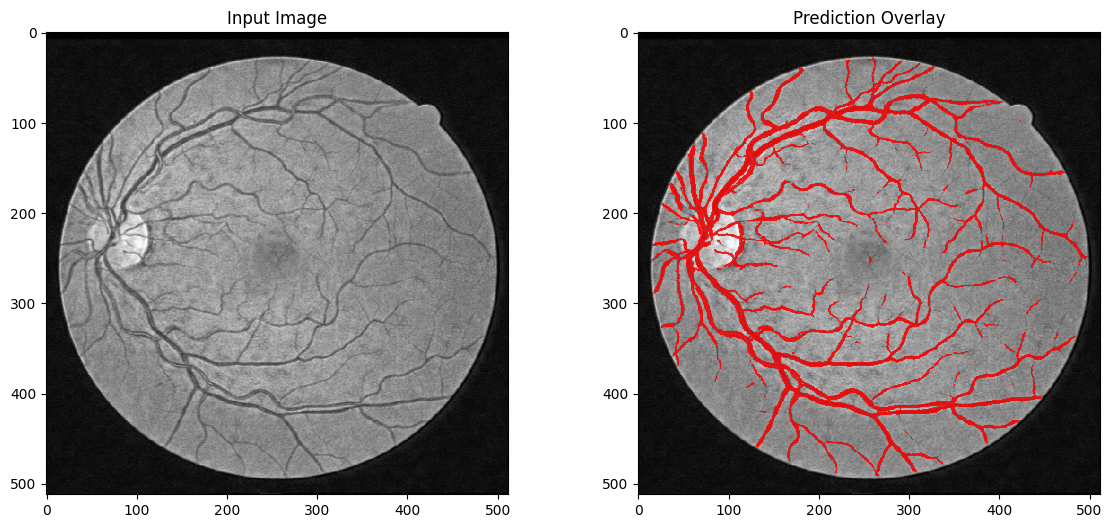

In [21]:
# Test dataset for now obtained from the training one (train_dict_list in monai.data.CacheDataset to obtain test_dataset) bacause the test dataset does not have useful masks
test_transform = monai.transforms.Compose([
    LoadVesselData(),  # ensures float32
    #monai.transforms.AddChanneld(keys=['img'])   #, 'mask']),
        #monai.transforms.ScaleIntensityd(keys=['img'],minv=0, maxv=1),
        #monai.transforms.Zoomd(keys=['img', 'mask'], zoom=0.25, keep_size=False, mode=['bilinear', 'nearest']),
    ###monai.transforms.EnsureTyped(keys=['img', 'mask'], dtype=torch.float32),  # Explicitly convert
])


test_dataset = monai.data.CacheDataset(test_dict_list, transform=test_transform)
test_loader = monai.data.DataLoader(test_dataset, batch_size=1)


for sample in test_loader:
    print("Test Image dtype:", sample["img"].dtype)  # Should be torch.float32
    #print("Test Mask dtype:", sample["mask"].dtype)  # Should be torch.float32
    print("Test Image shape:", sample["img"].shape)  # Should be [1, 1, 512, 512]
    break


for sample in test_loader:
    visual_evaluation_nomask_ensemble(sample, models,device)
    break

In [22]:
test_outputs = compute_test_predictions_weighted(test_loader, model_dice_dict, device)
print(f"Test set predictions computed for {len(test_outputs)} images")

Test set predictions computed for 20 images


# Export Predictions for the Grand-Challenge
https://drive.grand-challenge.org/evaluation/submissions/


In [23]:
models_for = config["ensemble_models"]
str_models = "___".join(models_for)

In [24]:
test_transform = Compose([
    LoadTestData(),  # Your MONAI-compatible test loader
])

save_outputs = '/'.join(config['save_model'].split('/')[:-1])  # e.g., '../saved_outputs'
os.makedirs(save_outputs, exist_ok=True)

save_path = f"{config['save_path']}_{str_models}"
zip_filename = f"{config['zip_filename']}_{str_models}.zip"
os.makedirs(save_path, exist_ok=True)

# 3. Ensemble Inference & Save Output Images
forced_size = (584, 565)  # original image shape
threshold_val = 0.5

print("🧠 Running ensemble prediction and saving masks...")
for i, sample in enumerate(tqdm(test_loader), 1):
    image = sample["img"].to(device)

    if image.dim() == 3:
        image = image.unsqueeze(0)  # [1, 1, H, W]

    with torch.no_grad():
        preds = []
        for m in models:
            m.eval()
            out = m(image)
            probs = torch.sigmoid(out)
            preds.append(probs.cpu())

        combined = torch.stack(preds).mean(dim=0)  # [1, 1, H, W]
        binary_mask = (combined > threshold_val).float()

    # Resize output mask to original shape
    resized_mask = F.interpolate(binary_mask, size=forced_size, mode='nearest')
    resized_mask_np = resized_mask.squeeze().cpu().numpy().astype(np.uint8) * 255

    # Save image
    filename = os.path.join(save_path, f"{i}.png")
    cv2.imwrite(filename, resized_mask_np)

print(f"✅ Saved all ensemble masks to: {save_path}")

# 4. Zip all saved images
print("📦 Creating zip archive...")
with zipfile.ZipFile(zip_filename, 'w') as zipf:
    for file in os.listdir(save_path):
        if file.endswith(".png"):
            zipf.write(os.path.join(save_path, file), arcname=file)

print(f"✅ Zip file created: {zip_filename}")

# 5. Optionally delete individual images
print("🧹 Cleaning up PNG files...")
for file in os.listdir(save_path):
    file_path = os.path.join(save_path, file)
    if file.endswith(".png") and os.path.isfile(file_path):
        os.remove(file_path)

os.rmdir(save_path)
print(f"✅ Cleaned up image files from: {save_path}")


🧠 Running ensemble prediction and saving masks...


100%|██████████| 20/20 [00:03<00:00,  5.69it/s]


✅ Saved all ensemble masks to: ../saved_outputs/output_images_swin_model___dropout_UNet
📦 Creating zip archive...
✅ Zip file created: ../saved_outputs/segmentation_outputs_swin_model___dropout_UNet.zip
🧹 Cleaning up PNG files...
✅ Cleaned up image files from: ../saved_outputs/output_images_swin_model___dropout_UNet


## robe per grafici

Test Image dtype: torch.float32
Test Image shape: torch.Size([1, 1, 512, 512])


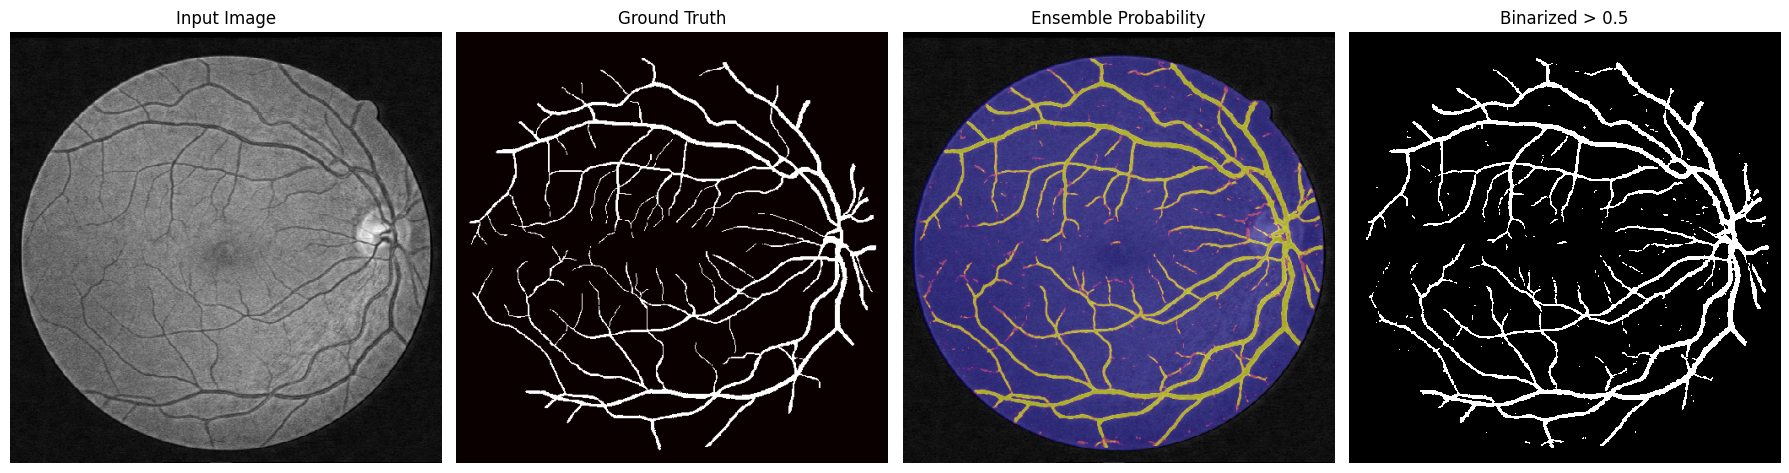

In [39]:
import matplotlib.pyplot as plt
import torch
import numpy as np
import monai

def visual_evaluation_4panels_ensemble(sample, models, device, method='average', threshold_val=0.5):
    """
    Visual evaluation with an ensemble (4 subplots):
      1) Input image
      2) Ground truth (if present)
      3) Ensemble probability map
      4) Binarized ensemble output
    
    Args:
        sample (dict): A dictionary with keys at least "img". Optionally "mask" and "valid_mask".
        models (list): List of PyTorch models for the ensemble.
        device (torch.device): Where models are loaded (CPU/CUDA).
        method (str): 'average' or 'vote' for ensemble combination.
        threshold_val (float): Threshold to binarize probability map.
    """
    sigmoid = torch.nn.Sigmoid()
    threshold_monai = monai.transforms.AsDiscrete(threshold_values=True)

    # 1) Prepare input image
    img_tensor = sample["img"].float().to(device)
    if img_tensor.dim() == 3:
        # shape [1, H, W] → add batch dimension
        img_tensor = img_tensor.unsqueeze(0)  # [B=1, C=1, H, W]
    img_np = sample["img"].squeeze().cpu().numpy()  # for plotting

    # 2) Optional ground truth
    has_gt = ("mask" in sample)

    # 3) Ensemble inference
    with torch.no_grad():
        preds = []
        for model in models:
            model.eval()
            output = model(img_tensor)       # raw logits shape: [1, 1, H, W]
            probs = sigmoid(output)          # convert to probabilities
            preds.append(probs.cpu())

        # Combine ensemble predictions
        if method == 'average':
            # Soft probability average
            combined = torch.stack(preds).mean(dim=0)  # [1, 1, H, W]
        elif method == 'vote':
            # majority vote among binarized preds
            binarized = [threshold_monai(p) for p in preds]  # each is 0 or 1
            combined = torch.stack(binarized).float().mean(dim=0)
            # combined is in [0..1], e.g. 0.6 means 3 of 5 models said "1"
        else:
            raise ValueError(f"Unsupported ensemble method: {method}")

    # Convert to NumPy
    combined_probs_np = combined.squeeze().numpy()  # shape [H, W], values in [0..1]
    
    # 4) Optionally apply valid_mask
    if "valid_mask" in sample:
        valid = sample["valid_mask"].squeeze().cpu().numpy()
        combined_probs_np *= valid

    # 5) Binarize final ensemble
    combined_bin_np = (combined_probs_np > threshold_val).astype(np.uint8)

    # ----- Plotting -----
    fig, axes = plt.subplots(1, 4, figsize=(18, 5))

    # (A) Input Image
    axes[0].imshow(img_np, cmap='gray')
    axes[0].set_title("Input Image")
    axes[0].axis("off")

    # (B) Ground Truth (if present)
    if has_gt:
        gt_np = sample["mask"].squeeze().cpu().numpy()
        axes[1].imshow(gt_np, cmap='hot')
        axes[1].set_title("Ground Truth")
    else:
        axes[1].text(0.5, 0.5, "No GT Provided",
                     ha="center", va="center", fontsize=12)
    axes[1].axis("off")

    # (C) Ensemble Probability
    # show continuous [0..1] map
    #axes[2].imshow(combined_probs_np, cmap='plasma', vmin=0.1, vmax=0.8)
    masked_probs = np.ma.masked_where(valid == 0, combined_probs_np)
    axes[2].imshow(img_np, cmap='gray')
    axes[2].imshow(masked_probs, cmap='plasma', alpha=0.6)
    
    axes[2].set_title("Ensemble Probability")
    axes[2].axis("off")

    # (D) Binarized Ensemble
    axes[3].imshow(combined_bin_np, cmap='gray', interpolation='none')
    axes[3].set_title(f"Binarized > {threshold_val}")
    axes[3].axis("off")

    plt.tight_layout()
    plt.savefig("ensemble_4panel_sample.png", bbox_inches='tight', dpi=300)

    plt.show()

val_loader = monai.data.DataLoader(val_dataset, batch_size=1)


for sample in val_loader:
    print("Test Image dtype:", sample["img"].dtype)  # Should be torch.float32
    #print("Test Mask dtype:", sample["mask"].dtype)  # Should be torch.float32
    print("Test Image shape:", sample["img"].shape)  # Should be [1, 1, 512, 512]
    break
    
for sample in val_loader:
    visual_evaluation_4panels_ensemble(sample, models, device, method='average', threshold_val=0.5)
    break

